## <font color=blue> Project: Churn Fortune Teller </font>

__Group:__ 1<br>
__Team Members:__<br>
1) Anirban Kar Chaudhuri (A0108517H) <br>
2) Maradana Vijaya Krishna (A0178453W) <br>
3) Putrevu Manoj Niyogi (A0213557E) <br>
4) Sivasankaran Balakrishnan (A0065970X)

## <font color=blue> Objectives: Model Training & Evaluation </font>
Machine reasoning if-else rules with forward-chaining inference used to generate new features.<br>
Training & Evaluation of Random Forest and Extreme Gradient Boosting Classifiers.

## <font color=blue> Overview: </font>

1) Machine Reasoning based on if-else rules hypothesized from data visualisations<br>
2) Random Forests vs Extreme Gradient Boosting Information <br>
3) Random Forest Classifier Training and Evaluation<br>
4) Extreme Gradient Forest Classifier Training and Evaluation<br>
5) Choosing A model for finetuning, interpretation and analysis (covered in script entitled __'XGBoost Finetuning & Analysis'__) <br>
6) Conclusive Statement

In [36]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import matplotlib.pyplot as plt#visualization
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization

churn_data=pd.read_pickle("customer_churn_data.pkl")
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   float64
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 1. Feature Engineering Using Machine Reasoning If-Else Rules (Forward Inference)

In [37]:
# A person is a family man if he has a spouse and dependents. 
#These groups of people chalk higher monthly bill and may churn
churn_data['Family_Person'] = np.where((churn_data['Dependents']=='Yes') & (churn_data['Partner']=='Yes'),1,0)


# Protection is defined by availability of security, backup and customer technical support
churn_data['Protection'] = np.where((churn_data['TechSupport'] == 'Yes') |\
                                    (churn_data['OnlineSecurity'] == 'Yes') |\
                                    (churn_data['OnlineBackup'] == 'Yes') |\
                                    (churn_data['DeviceProtection'] == 'Yes'),1,0)

# Total services - total counts of phone, internet, streaming and protection related services
churn_data['TotalServices'] = (churn_data[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

# Presence of internet determines churn probability as well as numerous facilities availability
churn_data['Has_Internet']=churn_data['InternetService'].replace(['Fiber optic','DSL','No'], [1,1,0])

# Presence of either streaming movies or TV show facilities determine if a customer is using streaming services
churn_data['Streaming'] = np.where((churn_data['StreamingTV']=='Yes') | (churn_data['StreamingMovies']=='Yes'),1,0)

# Manual check payment does not utilises advanced modern electronic technology
churn_data['Tech_Payment'] = np.where((churn_data['PaymentMethod']!='Mailed check'),1,0)

# A person is a techie if he utilises high-tech payment methods or enjoys streaming services
churn_data['Techie'] = np.where((churn_data['Streaming']==1) | (churn_data['Tech_Payment']==1),1,0)

# Premium services defined by fiber optic usage and multiple phone lines
churn_data['Premium_Services'] = np.where((churn_data['MultipleLines']=='Yes') & (churn_data['InternetService']=='Fiber optic'),1,0)


In [42]:
# People who have subscriptions for at least one year are committed customers
churn_data['Committed']=churn_data['Contract'].replace(['Two year','One year','Month-to-month'], [1,1,0])

# replacing string categories with numerical labels
churn_data['PhoneService']=churn_data['PhoneService'].replace(['Yes','No'], [1,0])
churn_data['PaperlessBilling']=churn_data['PaperlessBilling'].replace(['Yes','No'], [1,0])
churn_data['Dependents']=churn_data['Dependents'].replace(['Yes','No'], [1,0])
churn_data['Partner']=churn_data['Partner'].replace(['Yes','No'], [1,0])


In [4]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   float64
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


In [5]:
churn_data.to_pickle('ml-churn-data.pkl') #Save this dataframe containing newly processed data columns for a python pickle object

In [6]:
y=churn_data['Churn']

#Get rid of columns you don't wish to feed to machine learning models
drop_list=["customerID","Churn","gender","cluster","Partner","Dependents","StreamingTV","StreamingMovies","TechSupport",
           "OnlineSecurity","OnlineBackup","DeviceProtection","TotalCharges","MultipleLines","PhoneService","Contract",
          "InternetService","PaymentMethod"]
x=churn_data.drop(drop_list, axis=1)

In [7]:
def label_encoder(dataframe, col_name): # Function for label encoding categorical variables
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(dataframe[col_name].unique())
    dataframe[col_name] = le.transform(dataframe[col_name])
    
for i in list(x.columns[x.dtypes =='object']):
    label_encoder(x, i)

## 2. Random Forest vs Extreme Gradient Boost Trees

A single decision tree is a weak predictor, but is relatively fast to build. More trees give you a more robust model and prevent overfitting.<br>
Random Forests and Extreme Gradient Boosting algorithms are ensembles of invidual decision tree decisions being aggregated.

Random forests reduce the variance seen in decision trees by:<br>
1) Using different samples for training and specifying random feature subsets<br>
2) Building and combining small (shallow) trees<br>
3) However, the more trees you have, the slower the process. Each tree in the forest has to be generated, processed, and analyzed. In addition, the more features you have, the slower the process (which can sometimes take hours or even days); Reducing the set of features can dramatically speed up the process.<br>


__How trees are built:__ 

Random forests builds each tree independently while gradient boosting builds one tree at a time sequentially. This additive model (ensemble) works in a forward stage-wise manner, introducing a weak learner to improve the shortcomings of existing weak learners. 
Combining results: random forests combine results at the end of the process (by averaging or "majority rules") while gradient boosting combines results along the way.

Reference: https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained

### 2. Random Forest Classifier

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=8,stratify=y,train_size=0.75)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(5282, 13) (1761, 13) (5282,) (1761,)


In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, oob_score=True, n_estimators=30, random_state=8,
                            max_depth=8, class_weight={'No': 1, 'Yes': 1.8},n_jobs=-1,max_features=0.3,min_samples_leaf=5,
                           min_samples_split=5)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={'No': 1, 'Yes': 1.8}, criterion='gini',
                       max_depth=8, max_features=0.3, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=30, n_jobs=-1, oob_score=True,
                       random_state=8, verbose=0, warm_start=False)

Note: Churn customer category instances should be given higher weight set inside the __class_weight dictionary.__
Parameters worth playing with: Max depth, maximum number of features, number of estimators(decision trees)

In [28]:
rf.oob_score_

0.7881484286255206

In [29]:
rf_predictions = rf.predict(x_test)

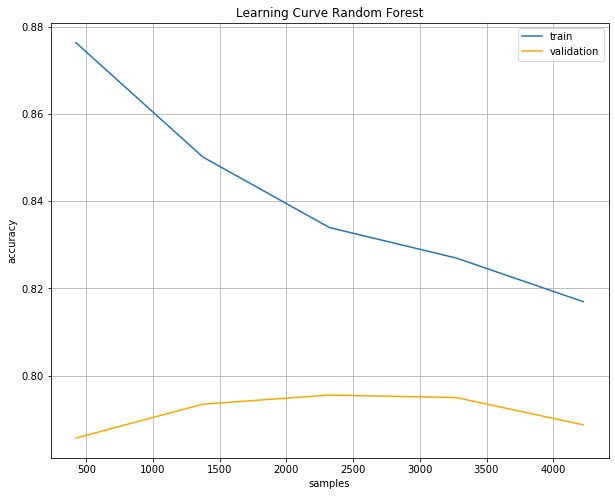

In [30]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model,titles):
    sample_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5,
                                                         random_state=42,n_jobs=-1)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(sample_sizes, train_scores.mean(axis=1), label='train')
    ax.plot(sample_sizes, val_scores.mean(axis=1), color='orange', label='validation')
    ax.set(xlabel='samples', ylabel='accuracy', title='Learning Curve {}'.format(titles))
    plt.grid()
    ax.legend()
    
plot_learning_curve(rf, titles='Random Forest')

Random Forest algorithm training and test scores are converging, indicating model is learning well.

In [31]:
from sklearn.model_selection import cross_validate

# cross validate
scores_rf = cross_validate(rf, x_train, y_train, cv=5, return_train_score=True,return_estimator=False)
scores_rf = pd.DataFrame(scores_rf)
scores_rf 

,fit_time,score_time,test_score,train_score
0,0.076137,0.111032,0.790918,0.816805
1,0.089761,0.106454,0.781457,0.815858
2,0.074482,0.111408,0.794508,0.815902
3,0.085234,0.111419,0.794508,0.814955
4,0.082812,0.106489,0.781250,0.820398


In [32]:
print('Mean Test Score for Random Forest Classifier: ', scores_rf['test_score'].mean())
print('Mean Train Score for Random Forest Classifier: ', scores_rf['train_score'].mean())

Mean Test Score for Random Forest Classifier:  0.7885279593474958
Mean Train Score for Random Forest Classifier:  0.81678337258504


[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'Random Forest Prediction')]

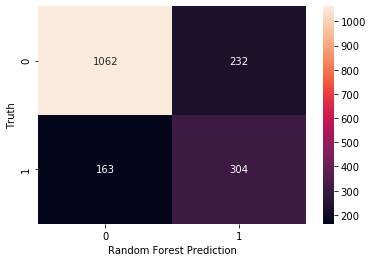

In [33]:
from sklearn.metrics import confusion_matrix

ax = sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt='d')
ax.set(xlabel='Random Forest Prediction', ylabel='Truth')

Confusion Matrix above shows count distributions of False Positives, False Negatives, True Positives and True Negatives.

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test,rf_predictions))

              precision    recall  f1-score   support

          No       0.87      0.82      0.84      1294
         Yes       0.57      0.65      0.61       467

    accuracy                           0.78      1761
   macro avg       0.72      0.74      0.72      1761
weighted avg       0.79      0.78      0.78      1761



Definitions of recall, precision and f1-score given below:
    
Accuracy = (TP+FP) / (TP+FP+TN+FN) <br>
Precision = TP / (TP + FP) <br>
Recall = Tp / (TP +FN) <br>
F1-Score = 2 * ((Precision * Recall) / (Precision + Recall))

In [17]:
def plot_feature_importances (model, kind, title, color, dataframe):
    importances = pd.Series(data=model.feature_importances_, index= dataframe.columns)
    # Sort importances
    importances_sorted = importances.sort_values()
    # Draw a horizontal barplot of importances_sorted
    importances_sorted.plot(kind=kind, color=color)
    plt.title(title)
    plt.grid()
    return(plt.show())

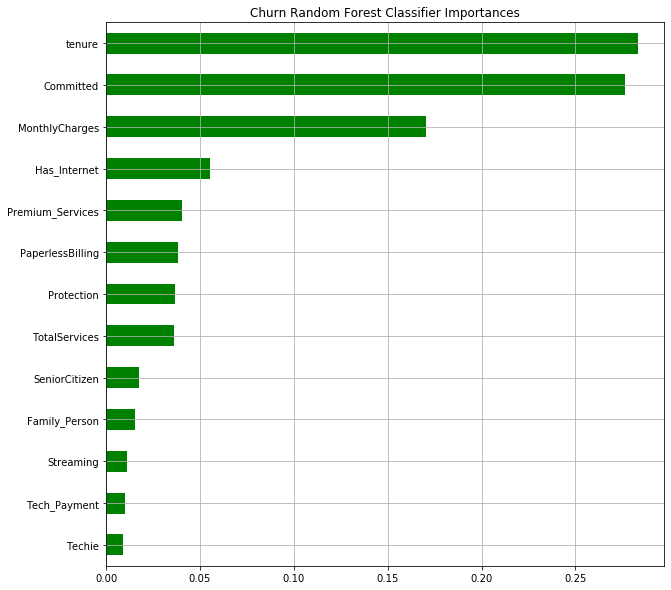

In [18]:
fig,ax=plt.subplots(figsize=(10,10))
plot_feature_importances (rf, 'barh', 'Churn Random Forest Classifier Importances', 'green', x_train)

15 features used for modelling.

### 3. Extreme Gradient Boosting Classifier

In [19]:
from xgboost import XGBClassifier

xgb=XGBClassifier(objective='reg:squarederror', n_estimators=12, max_depth=4,
                  learning_rate=0.5, seed=100,reg_lambda=0, reg_alpha=0.2, colsample_bynode=1,colsample_bytree=1,
                  scale_pos_weight=1.6)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=12, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=100, reg_alpha=0.2,
              reg_lambda=0, scale_pos_weight=1.6, seed=100, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [20]:
xgb_predictions = xgb.predict(x_test)

In [21]:
# cross validate
scores_xgb = cross_validate(xgb, x_train, y_train, cv=5, return_train_score=True,return_estimator=False)
scores_xgb = pd.DataFrame(scores_xgb)
scores_xgb 

,fit_time,score_time,test_score,train_score
0,0.027925,0.004986,0.799432,0.825799
1,0.025931,0.004987,0.786187,0.821538
2,0.027925,0.004987,0.785985,0.825367
3,0.024933,0.004987,0.801136,0.824420
4,0.028923,0.004987,0.775568,0.824894


In [22]:
print('Mean Test Score for XGBoost Classifier: ', scores_xgb['test_score'].mean())
print('Mean Train Score for XGBoost Classifier: ', scores_xgb['train_score'].mean())

Mean Test Score for XGBoost Classifier:  0.7896618144548608
Mean Train Score for XGBoost Classifier:  0.8244035654177997


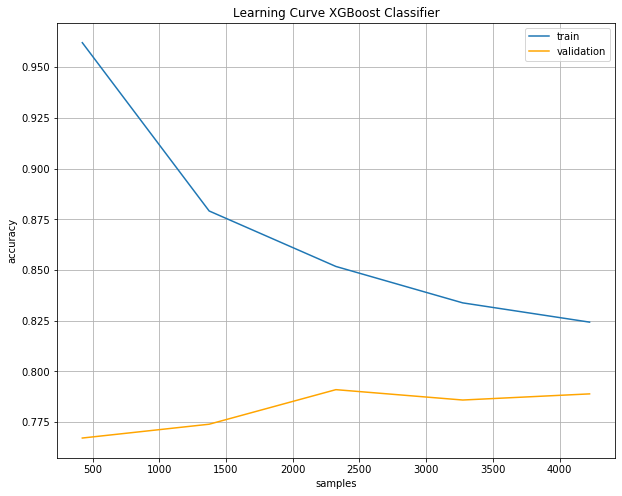

In [23]:
plot_learning_curve(xgb, titles='XGBoost Classifier')

[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'XGBoost Prediction')]

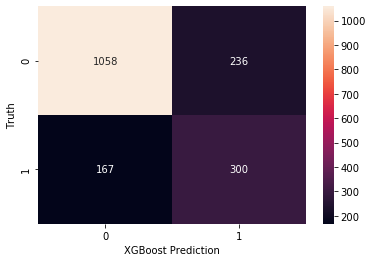

In [24]:
ax = sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot=True, fmt='d')
ax.set(xlabel='XGBoost Prediction', ylabel='Truth')

In [25]:
print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

          No       0.86      0.82      0.84      1294
         Yes       0.56      0.64      0.60       467

    accuracy                           0.77      1761
   macro avg       0.71      0.73      0.72      1761
weighted avg       0.78      0.77      0.78      1761



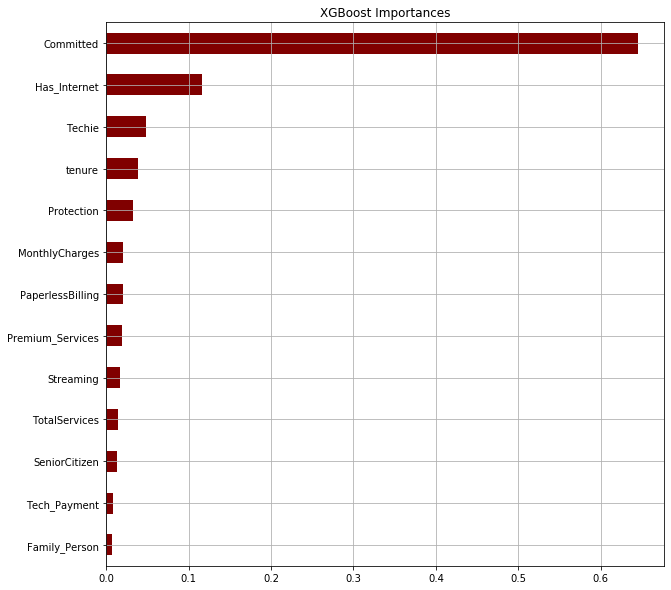

In [26]:
fig,ax=plt.subplots(figsize=(10,10))
plot_feature_importances (xgb, 'barh', 'XGBoost Importances', 'maroon', x_train)

## 4. Choice Of Model: Random Forest Classifier 

1) Higher __f-score__ (mean harmonic of precision and recall) as well as __accuracy__ <br>
2) Less likely to overfit based on learning curve & the difference in cross-validation mean training & test score. It makes better predictions on unseen data compared to XGBoost Classifier.

## 5. Conclusion: 

Trade off between false positives and false negatives. High false positives result in wastage of money spent on marketing campaigns. False negatives also pose a problem: customer leaving result in loss of revenue. F1-score takes into account mean harmonics of precision and recall (FP and FN both considered), useful during uneven class distribution.<br>

If you carefully tune parameters, gradient boosting can result in better performance than random forests. However, gradient boosting may not be a good choice if you have a lot of noise, as it can result in overfitting like seen here. They also tend to be harder to tune than random forests.